In [113]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn')

In [3]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [4]:
# We'll use this dataframe later for lookup
title_df.head()

,romaji,english,native,userPreferred
id,,,,
10161,No.6,No.6,NO.6 ナンバー・シックス,No.6
99726,Net-juu no Susume,Recovery of an MMO Junkie,ネト充のススメ,Net-juu no Susume
98526,Robomasters The Animated Series,NaN,ROBOMASTERS THE ANIMATED SERIES,Robomasters The Animated Series
966,Crayon Shin-chan,Shin Chan,クレヨンしんちゃん,Crayon Shin-chan
4876,Hashire Melos!,Run Melos!,走れメロス,Hashire Melos!


In [5]:
genres_item_matrix.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,mystery,psychological,romance,sci_fi,slice_of_life,sports,supernatural,thriller
id,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
tag_item_matrix.head()

,4_koma,achronological_order,acting,advertisement,afterlife,age_gap,age_regression,agender,airsoft,aliens,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.tail()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
99586,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
101283,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101633,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
101089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9832 entries, 10161 to 101089
Columns: 265 entries, action to zombie
dtypes: int64(265)
memory usage: 20.0 MB


In [10]:
df.describe()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
count,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,...,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000
mean,0.268002,0.213283,0.391172,0.190704,0.062449,0.198841,0.034886,0.025325,0.082994,0.097539,...,0.006001,0.018206,0.002034,0.001526,0.000305,0.003458,0.004577,0.011086,0.025427,0.005391
std,0.442941,0.409647,0.488038,0.392876,0.241982,0.399148,0.183501,0.157120,0.275888,0.297048,...,0.077236,0.133702,0.045058,0.039032,0.017466,0.058707,0.067501,0.104711,0.157427,0.073226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
total_per_feature = df.sum(axis=0)
total_per_feature

action       2635
adventure    2097
comedy       3846
drama        1875
ecchi         614
             ... 
yakuza         34
yandere        45
youkai        109
yuri          250
zombie         53
Length: 265, dtype: int64

In [12]:
total_per_show = df.sum(axis=1)
total_per_show

id
10161      9
99726     13
98526      5
966        9
4876      11
          ..
99586     11
99916      7
101283    18
101633    12
101089     3
Length: 9832, dtype: int64

In [13]:
total_per_show.rename('total_features_per_show')

id
10161      9
99726     13
98526      5
966        9
4876      11
          ..
99586     11
99916      7
101283    18
101633    12
101089     3
Name: total_features_per_show, Length: 9832, dtype: int64

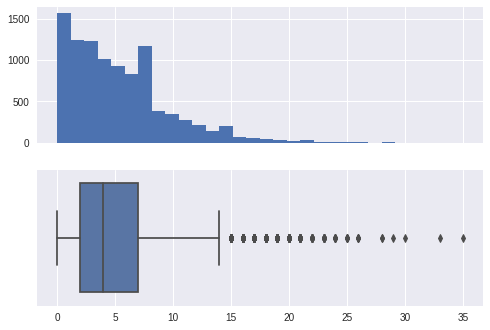

In [14]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].hist(total_per_show, bins=30)
ax[1] = sns.boxplot(total_per_show);

This seems potentially problematic. A majority of the shows don't have very many features. How many are needed to make an acurate recommendation?

In [15]:
def count_for_n_features(series, n):
    print('{0:.1%}'.format(len(series[series <= n]) / len(series)), 
          'or', len(series[series <= n]), f'shows have {n} or fewer features describing them.')


In [16]:
count_for_n_features(total_per_show, 2)

28.5% or 2805 shows have 2 or fewer features describing them.


In [17]:
count_for_n_features(total_per_show, 3)

41.0% or 4034 shows have 3 or fewer features describing them.


In [18]:
count_for_n_features(total_per_show, 4)

51.3% or 5047 shows have 4 or fewer features describing them.


While selecting which tags to keep, many were cut out because of a low "rank" score. Let's go back and keep all tags but normalize(standardize?) them. 

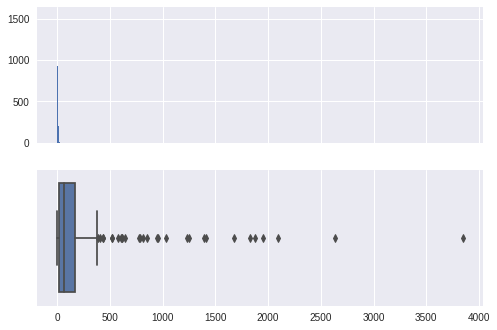

In [19]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].hist(total_per_show, bins=30)
ax[1] = sns.boxplot(total_per_feature);

In [20]:
# the tags below each describe 5 or fewer anime. They can be dropped without losing too much.
total_per_feature[total_per_feature < 6]

airsoft         5
asexual         4
badminton       2
bondage         5
calligraphy     4
centaur         5
cheerleading    5
ero_guro        4
feet            1
full_color      1
go              4
lacrosse        4
masturbation    1
netorare        4
pov             1
prostitution    1
reformation     1
rugby           3
surfing         3
table_tennis    4
teens_love      3
urination       1
vikings         2
voyeur          1
wuxia           3
dtype: int64

## Getting Recommendations

In [21]:
def jaccard_similarity(df):
    return (1 - pairwise_distances(df, metric="jaccard"))


def get_anime_id(search_term):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([search_term])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


def view_title_similarity(search_term, recom_titles):
    for title in recom_titles:
        seq_matcher = SequenceMatcher(None, search_term, title)
        print(f'The terms "{search_term}" and "{title}" are ' 
              + '{0:.2%}'.format(seq_matcher.quick_ratio()) + ' alike.')

In [22]:
cos_sim = cosine_similarity(df.values)

jac_sim = jaccard_similarity(df.values)

/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [23]:
def get_search_term(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title

<b>Recommendations should probably exclude titles from the same franchise.  
For example, try getting recommendations for Ghost in the Shell.  
If you already know you like Ghost in the Shell, it's pretty easy to find others in the same franchise if that's what you want.  </b>

First of all, our rudimentary search engine is failing...

In [24]:
initial_search = 'Ghost in the Shell'
search_term = get_search_term(initial_search)
search_term

'Koukaku Kidoutai'

In [25]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

['Ghost in the Shell: Stand Alone Complex - Solid State Society',
 'Harmony',
 'Ghost in the Shell Arise: Alternative Architecture',
 'PSYCHO-PASS Sinners of the System Case 1: Tsumi to Batsu',
 'Ghost in the Shell 2: Innocence',
 'Ghost in the Shell: Stand Alone Complex - The Laughing Man',
 'Ghost in the Shell: Stand Alone Complex 2nd GIG',
 'PSYCHO-PASS 2',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

In [26]:
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)
search_term

"Wolf's Rain"

In [27]:
id_list = get_anime_id(search_term)
id_list

202

In [40]:
n=5
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=n)
print('-----')
print(f'Top {n} based on {search_term}: \n{rec_list}')

-----
Top 5 based on Wolf's Rain: 
['Pokémon: Lucario and the Mystery of Mew', 'Final Fantasy VII: Last Order', 'Texhnolyze', 'Wan Wan Chuushingura', "Wolf's Rain OVA"]


In [41]:
view_title_similarity(search_term, rec_list)

The terms "Wolf's Rain" and "Pokémon: Lucario and the Mystery of Mew" are 28.00% alike.
The terms "Wolf's Rain" and "Final Fantasy VII: Last Order" are 30.00% alike.
The terms "Wolf's Rain" and "Texhnolyze" are 28.57% alike.
The terms "Wolf's Rain" and "Wan Wan Chuushingura" are 38.71% alike.
The terms "Wolf's Rain" and "Wolf's Rain OVA" are 84.62% alike.


Why is a Pokemon movie showing up as a recommendation based on Wolf's Rain? Also, why is Wan Wan Chuushingur being recommended. More on that one later. 

## Understanding Bad Recommendations

<tr>
    <td> <img src="https://upload.wikimedia.org/wikipedia/en/thumb/4/43/Wolf%27s_Rain_Region_2_Volume_1.jpg/220px-Wolf%27s_Rain_Region_2_Volume_1.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/95/Pok%C3%A9mon_Lucario_film_poster.jpg/220px-Pok%C3%A9mon_Lucario_film_poster.jpg" alt="Drawing" style="width: 250px;"/> </td>
    </tr>

In [ ]:
wr_id = title_df[title_df['english'] == "Wolf's Rain"].index
wr_df = df.loc[wr_id,:]

In [ ]:
# Genres and tags for Wolf's Rain
wr_df.loc[:, (wr_df != 0).any(axis=0)]

In [ ]:
pk_id = title_df[title_df['english'] == "Pokémon: Lucario and the Mystery of Mew"].index
pk_df = df.loc[pk_id,:]

In [ ]:
# Genres and tags for Pokémon: Lucario and the Mystery of Mew
pk_df.loc[:, (pk_df != 0).any(axis=0)]

Would it be wise to give a heavier weight to the "kids" column?

In [ ]:
sum(df['kids'])

In [ ]:
total_per_feature['kids']

In [ ]:
len(df)

In [ ]:
plt.bar(['Kids', 'Not Kids'], [total_per_feature['kids'], len(df) - total_per_feature['kids']]);

In [ ]:
plt.hist(total_per_feature, bins=50)
plt.ylabel('Number of Tags')
plt.xlabel('Total Number of Shows Per Tag');

In [ ]:
for tag, count in total_per_feature.sort_values(ascending=False).iteritems():
    print(tag, count)

<b>Would like to penalize features that describe a large number of shows (i.e. comedy) and give a heavier weight to those that describe fewer shows.  
The normalization should be strong enough to not recommend a Pokemon movie when looking at "Wolf's Rain" but not so strong that all recommendations are based on the rarest tag. </b>

In [ ]:
initial_search = 'Ghost in the Shell'
search_term = get_search_term(initial_search)
search_term

In [ ]:
# using cosine similarity 
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

<b> The search is working but maybe we're returning too many from the same franchise.</b>

In [ ]:
view_title_similarity('Ghost in the Shell', rec_list)

In [ ]:
seq_matcher = SequenceMatcher(None, 
                              "Ghost in the Shell Arise: Alternative Architecture", 
                              "Ghost in the Shell: Stand Alone Complex 2nd GIG")
seq_matcher.quick_ratio()

This is one problem with the recommender. The recommendations are good but too many are not very useful for a user. Future work on the project would include going through and filtering out titles from the same franchise or only including one title per franchise. 

In [ ]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=25)
rec_list

In [ ]:
## top 10 while limiting 1 per franchise
['Appleseed',
 'New Cutey Honey',
 'Armitage III',
 'Fireball Charming',
 'Jin-Roh: The Wolf Brigade',
 'Ergo Proxy',
 'The Animatrix',
 'Mardock Scramble: The Second Combustion',
 'Harmony',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

## Comparing Cosine Similarity and Jaccard

We can do Jaccard because our data is still binary

### Samurai Champloo

In [ ]:
initial_search = 'Samurai Champloo'
search_term = get_search_term(initial_search)
search_term

In [ ]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

In [ ]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, jac_sim, n=10)
rec_list

Cosine similarity and jaccard similarity are returning similar results.

In [42]:
def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]
    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)

In [ ]:
champloo_tags = view_features(get_search_term('Samurai Champloo'), df)
champloo_tags

In [ ]:
# Blade of the Immortal scored higher with cosine similarity than jaccard similarity
blade_immortal_tags = view_features(get_search_term("Blade of the Immortal"), df)
blade_immortal_tags

In [ ]:
# "Ranma ½: One Flew Over the Kuno's Nest" scored higher with jaccard similarity than cosine similarity
ranma_tags = view_features(get_search_term("Ranma ½: One Flew Over the Kuno's Nest"), df)
ranma_tags

Both have a "supernatural" tag while "Samurai Champloo" does not.  
"Action" and "Adventure" are present for all three.  
"Blade of the Immortal" shares "historical", "samurai", and "swordplay"  
"Ranma ½: One Flew Over the Kuno's Nest" shares "comedy", "martial_arts", and "shounen".

In [ ]:
temp_categories = total_per_feature[total_per_feature.index.isin(['action', 
                                                                  'adventure', 
                                                                  'supernatural', 
                                                                  'historical', 
                                                                  'samurai', 
                                                                  'swordplay', 
                                                                  'comedy', 
                                                                  'martial_arts', 
                                                                  'shounen'])]
plt.bar(temp_categories.index, temp_categories)
plt.title('Number of Shows Per Genre/Tag');

Not sure what's going on but it appears jaccard similarity may be favoring more common features.  
To Be Continued...

## Diving into EDA

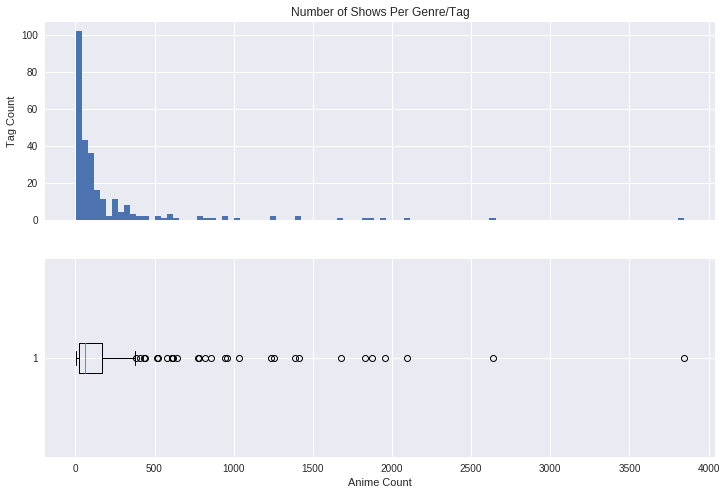

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax[0].hist(total_per_feature, bins=100)
ax[0].set_title('Number of Shows Per Genre/Tag')
ax[0].set_ylabel('Tag Count')

ax[1].boxplot(total_per_feature, vert=False)
ax[1].set_xlabel('Anime Count');

### Genres

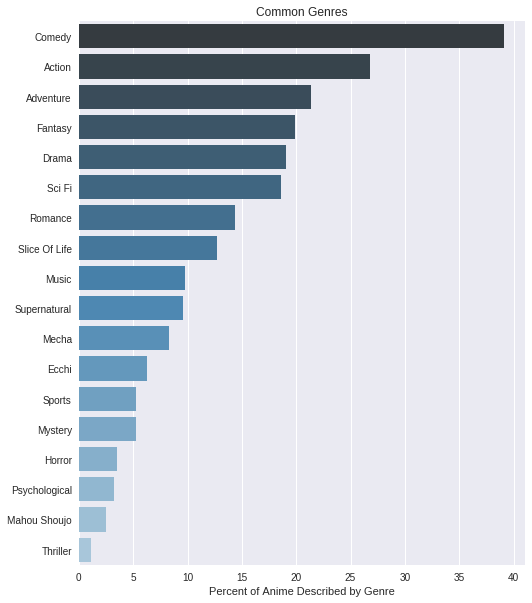

In [30]:
sorted_genres = genres_item_matrix.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 10))
ax = sns.barplot([((x/len(df)) * 100) for x in sorted_genres], 
                 [(x.replace('_', ' ')).title() for x in sorted_genres.index], 
                 orient='h', palette='Blues_d')
ax.set_title('Common Genres')
ax.set_xlabel('Percent of Anime Described by Genre');

<b>Slice of Life</b> - depiction of everyday life experiences of (usually) ordinary people

<b>Mecha</b> - giant robots

<b>Ecchi</b> - defined by Wikipedia as "an often used slang term in the Japanese language for playfully sexual actions"

<b>Mahou Shoujo</b> - magical girl


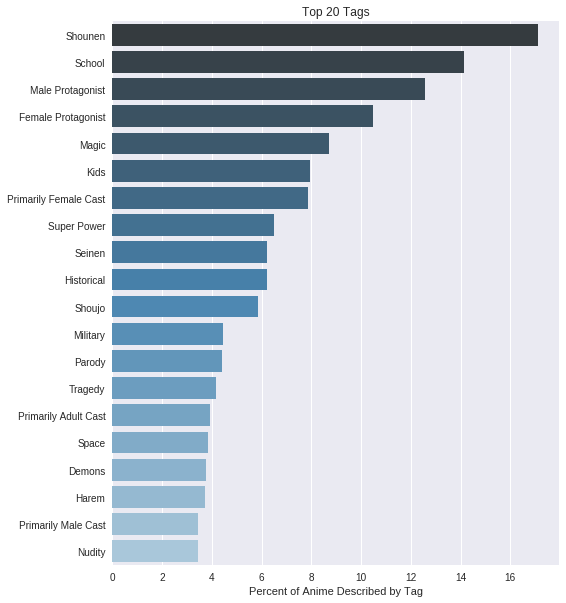

In [31]:
sorted_tags = tag_item_matrix.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 10))
count=20
ax = sns.barplot([((x/len(df)) * 100) for x in sorted_tags[:count]], 
                 [(x.replace('_', ' ')).title() for x in sorted_tags.index[:count]], 
                 orient='h', palette='Blues_d')
ax.set_title(f'Top {count} Tags')
ax.set_xlabel('Percent of Anime Described by Tag');

<b>Shounen</b> - manga and anime marketed towards teenage males. 

<b>Seinen</b> - manga and anime marketed towards young adult men.

<b>Shoujo</b> - manga and anime marketed towards teenage females.

## Weighing Features

In [32]:
tag_rank_item_matrix.head()

,4_koma,achronological_order,acting,advertisement,afterlife,age_gap,age_regression,agender,airsoft,aliens,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [33]:
df_w_rank = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [34]:
cos_sim_rank = cosine_similarity(df_w_rank.values)

In [35]:
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=5)


In [36]:
# boolean matrix
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)

id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

['Sky Blue',
 'Vampire Hunter D: Bloodlust',
 'Miracle Psychicer Seizan',
 'Mujin Wakusei Survive',
 'Planetarian',
 'Pokémon: Lucario and the Mystery of Mew',
 'Final Fantasy VII: Last Order',
 'Texhnolyze',
 'Wan Wan Chuushingura',
 "Wolf's Rain OVA"]

In [37]:
# Accounting for tag relevance to title
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)

id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df_w_rank, cos_sim_rank, n=10)
rec_list

['Ancien to Mahou no Tablet: Mou Hitotsu no Hirune Hime',
 'Shen Qi Huan Qi Tan',
 'Chrome Shelled Regios',
 'Pokémon: Lucario and the Mystery of Mew',
 'Kingsglaive Final Fantasy XV',
 'Wan Wan Chuushingura',
 "Wolf's Rain OVA",
 'Galilei Donna',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Final Fantasy VII: Last Order']

<b>Using rank pushed the Pokemon recommendation back. That's a good sign.</b>  
'Wan Wan Chuushingura' is still present through. Why?

In [44]:
view_features(get_search_term("Wolf's Rain"), df_w_rank)

['action',
 'adventure',
 'drama',
 'fantasy',
 'mystery',
 'sci_fi',
 'animals',
 'dystopian',
 'post_apocalyptic',
 'primarily_adult_cast',
 'survival',
 'tragedy',
 'werewolf']

In [45]:
view_features(get_search_term('Wan Wan Chuushingura'), df_w_rank)

['action', 'adventure', 'drama', 'fantasy', 'animals']

All of the tags for "Wan Wan Chuushingura" are also tags for "Wolf's Rain" but there are a few missing that are very important. This goes back to a problem noticed earlier. Our data is more sparce than what is ideal. We need more tags for "Wan Wan Chuushingura" for our recommender to see that maybe this isn't a great suggestion based on Wolf's Rain.  
Would it be worth penalizing titles with fewer features?  
Or maybe we just cut out titles with fewer features? 

### Penalization Vectors

In [56]:
score_df = pd.read_csv('data/score_df.csv', index_col='id')

In [57]:
score_df.head()

,averageScore,popularity
id,,
10161,71.0,27608
99726,75.0,41540
98526,58.0,1901
966,73.0,4681
4876,61.0,921


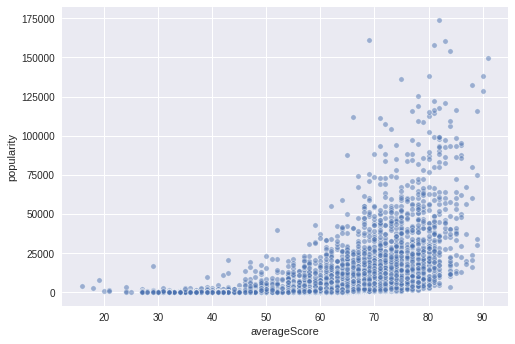

In [58]:
sns.scatterplot(score_df['averageScore'], 
                score_df['popularity'], 
                s=30, 
                alpha=.5);

In [130]:
# popular yet poorly rated
x = score_df[(score_df['averageScore'] < 30) & (score_df['popularity'] > 15000)]

get_title_from_id(x.index.values[0])

'Pupa'

In [65]:
top_10_pop = list(score_df['popularity'].sort_values()[-10:].index)
top_10_pop

[21519, 20605, 19815, 9253, 5114, 21087, 21459, 1535, 11757, 16498]

In [74]:
top_10_score = list(score_df['averageScore'].sort_values().dropna()[-10:].index)
top_10_score

[15417, 15335, 820, 21745, 104578, 20996, 20954, 9253, 11061, 5114]

In [64]:
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title

In [66]:
for _id in top_10_pop:
    print(get_title_from_id(_id))

Your Name.
Tokyo Ghoul
No Game, No Life
Steins;Gate
Fullmetal Alchemist: Brotherhood
One-Punch Man
My Hero Academia
Death Note
Sword Art Online
Attack on Titan


In [75]:
for _id in top_10_score:
    print(get_title_from_id(_id))

Gintama Season 3
Gintama: The Final Chapter - Be Forever Yorozuya
Legend of the Galactic Heroes
Owarimonogatari Second Season
Attack on Titan Season 3 Part 2
Gintama Season 4
A Silent Voice
Steins;Gate
Hunter x Hunter (2011)
Fullmetal Alchemist: Brotherhood


To confirm, popularity is not based on averageScore

In [87]:
score_df['popularity'].sort_values().index

Int64Index([115436, 118675, 116058, 118050, 118048, 117792, 115198, 117928,
            118112, 117794,
            ...
             21519,  20605,  19815,   9253,   5114,  21087,  21459,   1535,
             11757,  16498],
           dtype='int64', name='id', length=9832)

In [98]:
sorted_pop = score_df['popularity'].sort_values()
for num, idx_pop in enumerate(sorted_pop.items()):
    score_df.loc[idx_pop[0], 'pop_rank'] = num


In [99]:
score_df

,averageScore,popularity,pop_rank
id,,,
10161,71.0,27608,9376
99726,75.0,41540,9573
98526,58.0,1901,6538
966,73.0,4681,7702
4876,61.0,921,5544
...,...,...,...
99586,65.0,15135,8928
99916,76.0,9351,8467
101283,67.0,25665,9335


In [104]:
for _id in list(score_df['pop_rank'].sort_values()[-10:].index):
    print(get_title_from_id(_id))


Your Name.
Tokyo Ghoul
No Game, No Life
Steins;Gate
Fullmetal Alchemist: Brotherhood
One-Punch Man
My Hero Academia
Death Note
Sword Art Online
Attack on Titan


In [119]:
scaler = MinMaxScaler()
scaled_pop = scaler.fit_transform(score_df['popularity'].to_numpy().reshape(-1, 1))

In [155]:
for _id in list(score_df['pop_scaled'].sort_values()[-10:].index):
    print(_id, get_title_from_id(_id))


21519 Your Name.
20605 Tokyo Ghoul
19815 No Game, No Life
9253 Steins;Gate
5114 Fullmetal Alchemist: Brotherhood
21087 One-Punch Man
21459 My Hero Academia
1535 Death Note
11757 Sword Art Online
16498 Attack on Titan


In [120]:
score_df.head()

,averageScore,popularity,pop_rank,pop_scaled
id,,,,
10161,71.0,27608,9376,0.158971
99726,75.0,41540,9573,0.239225
98526,58.0,1901,6538,0.010887
966,73.0,4681,7702,0.026901
4876,61.0,921,5544,0.005242


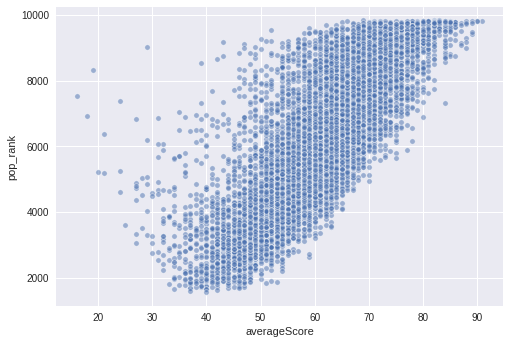

In [121]:
sns.scatterplot(score_df['averageScore'], 
                score_df['pop_rank'], 
                s=30, 
                alpha=.5);

In [131]:
score_df['score_scaled'] = score_df['averageScore'] / 100

In [132]:
score_df

,averageScore,popularity,pop_rank,pop_scaled,score_scaled
id,,,,,
10161,71.0,27608,9376,0.158971,0.71
99726,75.0,41540,9573,0.239225,0.75
98526,58.0,1901,6538,0.010887,0.58
966,73.0,4681,7702,0.026901,0.73
4876,61.0,921,5544,0.005242,0.61
...,...,...,...,...,...
99586,65.0,15135,8928,0.087121,0.65
99916,76.0,9351,8467,0.053802,0.76
101283,67.0,25665,9335,0.147778,0.67


In [133]:
score_df['pop_scaled'].sort_values()

id
115436    0.000000
118675    0.000000
116058    0.000000
118050    0.000000
118048    0.000006
            ...   
21087     0.888864
21459     0.910091
1535      0.922799
11757     0.928311
16498     1.000000
Name: pop_scaled, Length: 9832, dtype: float64

In [219]:
a = .1
score_df['adjusted_score'] = ((a * score_df['pop_scaled']) + .9) * score_df['score_scaled']

In [220]:
score_df = score_df.fillna(value=0)

In [221]:
top_15_df = score_df.sort_values(by='adjusted_score').tail(15)
top_15_df

,averageScore,popularity,pop_rank,pop_scaled,score_scaled,adjusted_score
id,,,,,,
21745,89.0,34193,9488,0.196903,0.89,0.818524
16498,82.0,173609,9831,1.000000,0.82,0.820000
199,86.0,94132,9789,0.542178,0.86,0.820627
1,86.0,95392,9792,0.549436,0.86,0.821252
20665,85.0,116353,9814,0.670181,0.85,0.821965
21698,88.0,60233,9709,0.346905,0.88,0.822528
1535,83.0,160207,9829,0.922799,0.83,0.823592
21087,84.0,154316,9827,0.888864,0.84,0.830665
101338,88.0,79855,9758,0.459936,0.88,0.832474


In [222]:
title_df.loc[list(top_15_df.index.values),:]

,romaji,english,native,userPreferred
id,,,,
21745,Owarimonogatari (Ge),Owarimonogatari Second Season,終物語（下）,Owarimonogatari (Ge)
16498,Shingeki no Kyojin,Attack on Titan,進撃の巨人,Shingeki no Kyojin
199,Sen to Chihiro no Kamikakushi,Spirited Away,千と千尋の神隠し,Sen to Chihiro no Kamikakushi
1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,Cowboy Bebop
20665,Shigatsu wa Kimi no Uso,Your Lie in April,四月は君の嘘,Shigatsu wa Kimi no Uso
21698,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,HAIKYU!! 3rd Season,ハイキュー!! 烏野高校 VS 白鳥沢学園高校,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...
1535,Death Note,Death Note,DEATH NOTE,Death Note
21087,One Punch Man,One-Punch Man,ワンパンマン,One Punch Man
101338,Mob Psycho 100 II,Mob Psycho 100 II,モブサイコ100 II,Mob Psycho 100 II


In [234]:
# score_df[['pop_scaled', 'score_scaled', 'adjusted_score']].to_csv('data/adjusted_score_df.csv')

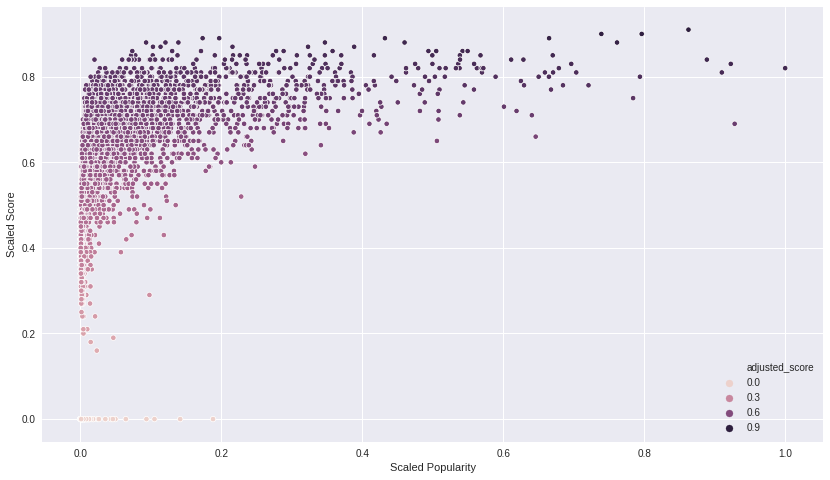

In [232]:
fig, ax = plt.subplots(figsize=(14,8))
sns.scatterplot(x='pop_scaled', 
                y= 'score_scaled',
                data=score_df,
                s=30, 
                hue='adjusted_score')
ax.set_xlabel('Scaled Popularity')
ax.set_ylabel('Scaled Score');